In [90]:
import numpy as np
import numpy as np
from scipy.spatial import cKDTree
from scipy.special import psi, gammaln  # digamma, log-gamma
import matplotlib.pyplot as plt

In [ ]:
# Kozachenko–Leonenko entropy estimator


# compute the average log difference of the sliding window
def entropy_kl(X:np.ndarray[np.ndarray[float]], k=3,max_norm=True):

    if X.ndim == 1: 
        X = X[:, None]
    N, d = X.shape

    tree = cKDTree(X)
    
    if max_norm:
        rho = tree.query(X, k=k+1, p=np.inf, workers=-1)[0][:, -1] 
        log_c_d = 2**d 
         
    else:
        rho = tree.query(X, k=k+1, p=2.0, workers=-1)[0][:, -1]  
        log_c_d = (d/2)*np.log(np.pi) - gammaln(d/2 + 1.0) # volume of the d-dimensional unit ball under the max norm 
    
    H = psi(N) - psi(k) + log_c_d + d*(np.log(2.0) + np.mean(np.log(rho)))
    
    return H

    

    

In [ ]:
# KSG mutual information estimator https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
def MI_estimate(X,Y,k=3):
    
    N = X.shape[0]
    
    Z = np.concatenate([X, Y], axis=1)
    
    treeZ = cKDTree(Z)
    
    dists, _ = treeZ.query(Z, k=k+1, p=np.inf,workers=-1)
    
    
    eps = dists[:, -1]  # distance to k-th neighbor (excluding self)
    
    
    
    tiny = 1e-15
    # all joint neighbors within ε(i)
    joint = treeZ.query_ball_point(Z, r=eps + tiny, p=np.inf, workers=-1)
    
    ex = np.empty(len(X))
    ey = np.empty(len(X))
    
    for i, nbr in enumerate(joint):
        if i in nbr: 
            nbr.remove(i)  
            
            
        ex[i] = np.max(np.abs(X[nbr] - X[i]), axis=1).max()
        ey[i] = np.max(np.abs(Y[nbr] - Y[i]), axis=1).max()
        
    treeX = cKDTree(X)
    treeY = cKDTree(Y)
    
    nx = np.array([len(treeX.query_ball_point(X[i], r=ex[i] + tiny, p=np.inf))-1 for i in range(len(X))])
    ny = np.array([len(treeY.query_ball_point(Y[i], r=ey[i] + tiny, p=np.inf))-1 for i in range(len(Y))])

  

    MI = psi(k) - (1.0 / k) - np.mean(psi(nx) + psi(ny)) + psi(N)
    
    
    
    return MI


In [191]:
sigma = 100.0
mu = 0.0
# Generate data from a 5-dimensional Gaussian with off-diagonal covariance r=0.9
n_dim = 3
r = 0.5
n_samples = 10000000


# Construct the covariance matrix: 1 on diagonal, r elsewhere
cov = np.full((n_dim, n_dim), r)
np.fill_diagonal(cov, sigma)

mu_vec = np.zeros(n_dim)
gaussian_5d_corr_data = np.random.multivariate_normal(mean=mu_vec, cov=cov, size=n_samples)

# print("Shape of correlated 5D Gaussian data:", gaussian_5d_corr_data.shape)
# print("First 3 samples:\n", gaussian_5d_corr_data[:3])

det_cov = np.linalg.det(cov)
# print("Determinant of the covariance matrix:", det_cov)
true_entropy = n_dim * 0.5 * np.log(2 * np.pi * np.exp(1) * sigma**2)
entropy_estimate = entropy_kl(gaussian_5d_corr_data,k=2,max_norm=True)
print(f"true entropy: {true_entropy}")
print(entropy_estimate)
print(abs(entropy_estimate - true_entropy))

true entropy: 18.072326157578292
19.163170355711422
1.09084419813313


In [133]:
# Generate data from a 5-dimensional Gaussian (standard normal)
n_samples = 10000
n_dim = 5
gaussian_5d_data = np.random.normal(loc=0.0, scale=1.0, size=(n_samples, n_dim))
print("Shape of 5D Gaussian data:", gaussian_5d_data.shape)
print("First 3 samples:\n", gaussian_5d_data[:3])

Shape of 5D Gaussian data: (10000, 5)
First 3 samples:
 [[-0.13031004  0.534565    0.78963719  2.29357753  0.88486991]
 [ 0.39578799  0.69691351  0.3097625  -1.50553736 -0.87486841]
 [ 0.62972001  0.65990734 -2.22977281 -1.68466771  0.1650419 ]]


In [93]:
n_samples = [50,100,200,400,800,1600]
rs = [0.9,0.6,0.3,0.0]
n_dim = 2
num_seeds = 100
# for n_sample in n_samples:

mi_data = {}
for r in rs:

    mis = []
    for n_sample in n_samples:
        mi_samples = []
        for i in range(num_seeds):
            rng = np.random.RandomState(i)

            cov = np.full((n_dim, n_dim), r)
            np.fill_diagonal(cov, 1.0)

            mu = rng.normal(0,1,n_dim)



            # Generate samples
            gaussian_data = rng.multivariate_normal(mean=mu, cov=cov, size=n_sample)

            X = gaussian_data[:,0].reshape(-1,1)
            Y = gaussian_data[:,1].reshape(-1,1)
            
            mi = MI_estimate(X,Y,k=3)
            mi_samples.append(mi)
        mi_estimate = np.mean(np.array(mi_samples))
        print('appending ',mi_estimate)
        mis.append(mi_estimate)
    mi_data[r] = np.array(mis)
    
    

appending  0.7767018610857308
appending  0.826502643910121
appending  0.8536254553890308
appending  0.8474612045800783
appending  0.8444178621559578
appending  0.8394508338733847
appending  0.2061961809232643
appending  0.2274981290057066
appending  0.23988373155933387
appending  0.23104557787235955
appending  0.2264472420087564
appending  0.2261344943773853
appending  0.03493786561470399
appending  0.0461778459408855
appending  0.06124254983761762
appending  0.052439888097198434
appending  0.046137442810674154
appending  0.047373833713435294
appending  -0.01486781953202312
appending  0.004543687996641736
appending  0.01754398157258059
appending  0.006811491918270729
appending  0.0007654275198006211
appending  -0.0015699722989871566


In [80]:
mi_data[0.6]

array([0.20619618, 0.22749813, 0.23988373, 0.23104558, 0.22644724,
       0.22613449])

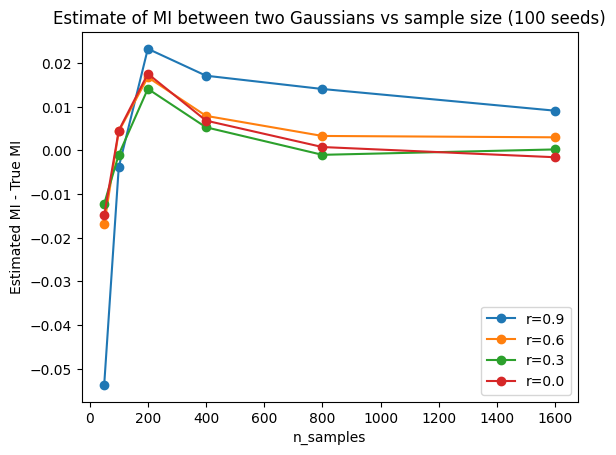

In [94]:


true_mi = lambda r:  -0.5*np.log(1-r**2)

for i in rs:
    mi_arr = mi_data[i]
    diff_arr = mi_arr - true_mi(i) 
    plt.plot(np.array(n_samples),diff_arr,'o-',label='r='+str(i))

plt.legend()
plt.ylabel('Estimated MI - True MI')
plt.xlabel('n_samples')
plt.title('Estimate of MI between two Gaussians vs sample size (100 seeds)')
plt.show()

In [172]:
ests = []

for i in range(100):
    rng = np.random.RandomState(i)
    n_dim = 64
    r = 0.5
    n_sample = 1000
    cov = np.full((n_dim, n_dim), r)
    np.fill_diagonal(cov, 1.0)

    mu = rng.normal(0,1,n_dim)



    # Generate samples
    gaussian_data_multi_var = rng.multivariate_normal(mean=mu, cov=cov, size=n_sample)
    X = gaussian_data_multi_var[:,:-1]
    Y = gaussian_data_multi_var[:,-1].reshape(-1,1)
    
    ests.append(MI_estimate(X,Y,k=3))
    
print(sum(ests)/len(ests))


0.29008912267144926


In [173]:
c = r*np.ones(n_dim)
R = c @ np.linalg.inv(cov) @ c
true_mi = -0.5*np.log(1 - R**2)

print(true_mi)


0.13877799991070494


In [169]:
MI_estimate(X,Y,k=3)

np.float64(1.036749813252701)